# Hyperparameter tuning by grid-search

In the previous notebook, we saw that hyperparameters can affect the
generalization performance of a model. In this notebook, we show how to
optimize hyperparameters using a grid-search approach.

## Our predictive model

Let us reload the dataset as we did previously:

In [1]:
import pandas as pd

adult_census = pd.read_csv("../datasets/adult-census.csv")

We extract the column containing the target.

In [2]:
target_name = "class"
target = adult_census[target_name]
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

We drop from our data the target and the `"education-num"` column which
duplicates the information from the `"education"` column.

In [3]:
data = adult_census.drop(columns=[target_name, "education-num"])
data

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
48838,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
48839,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
48840,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


Once the dataset is loaded, we split it into a training and testing sets.

In [4]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)

We define a pipeline as seen in the first module, to handle both numerical and
categorical features.

The first step is to select all the categorical columns.

In [5]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

Here we use a tree-based model as a classifier (i.e.
`HistGradientBoostingClassifier`). That means:

* Numerical variables don't need scaling;
* Categorical variables can be dealt with an `OrdinalEncoder` even if the
  coding order is not meaningful;
* For tree-based models, the `OrdinalEncoder` avoids having high-dimensional
  representations.

We now build our `OrdinalEncoder` by passing it the known categories.

In [6]:
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

We then use `make_column_transformer` to select the categorical columns and apply
the `OrdinalEncoder` to them.

In [7]:
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer(
    (categorical_preprocessor, categorical_columns),
    remainder="passthrough",
    # Silence a deprecation warning in scikit-learn v1.6 related to how the
    # ColumnTransformer stores an attribute that we do not use in this notebook
    force_int_remainder_cols=False,
)

Finally, we use a tree-based classifier (i.e. histogram gradient-boosting) to
predict whether or not a person earns more than 50 k$ a year.

In [8]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4),
        ),
    ]
)
model

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ordinalencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Tuning using a grid-search

In the previous exercise (M3.01) we used two nested `for` loops (one for each
hyperparameter) to test different combinations over a fixed grid of
hyperparameter values. In each iteration of the loop, we used
`cross_val_score` to compute the mean score (as averaged across
cross-validation splits), and compared those mean scores to select the best
combination. `GridSearchCV` is a scikit-learn class that implements a very
similar logic with less repetitive code. The suffix `CV` refers to the
cross-validation it runs internally (instead of the `cross_val_score` we
"hard" coded).

The `GridSearchCV` estimator takes a `param_grid` parameter which defines all
hyperparameters and their associated values. The grid-search is in charge of
creating all possible combinations and testing them.

The number of combinations is equal to the product of the number of values to
explore for each parameter. Thus, adding new parameters with their associated
values to be explored rapidly becomes computationally expensive. Because of
that, here we only explore the combination learning-rate and the maximum
number of nodes for a total of 4 x 3 = 12 combinations.

In [9]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": (0.01, 0.1, 1, 10),  # 4 possible values
    "classifier__max_leaf_nodes": (3, 10, 30),  # 3 possible values
}  # 12 unique combinations
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=2)
model_grid_search.fit(data_train, target_train)

/home/karansinghthakor/.local/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/karansinghthakor/.local/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/karansinghthakor/.local/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/karansinghthakor/.local/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `

CPU times: user 2.52 s, sys: 76.2 ms, total: 2.6 s
Wall time: 7.33 s


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__learning_rate': (0.01, ...), 'classifier__max_leaf_nodes': (3, ...)}"
,scoring,None
,n_jobs,2
,refit,True
,cv,2
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ordinalencoder', ...)]"


You can access the best combination of hyperparameters found by the grid
search using the `best_params_` attribute.

In [10]:
print(f"The best set of parameters is: {model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


Once the grid-search is fitted, it can be used as any other estimator, i.e. it
has `predict` and `score` methods. Internally, it uses the model with the
best parameters found during `fit`.

Let's get the predictions for the 5 first samples using the estimator with the
best parameters:

In [11]:
model_grid_search.predict(data_test.iloc[0:5])

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

Finally, we check the accuracy of our model using the test set.

In [12]:
accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-search pipeline is: {accuracy:.2f}"
)

The test accuracy score of the grid-search pipeline is: 0.88


The accuracy and the best parameters of the grid-search pipeline are similar
to the ones we found in the previous exercise, where we searched the best
parameters "by hand" through a double `for` loop.

## The need for a validation set

In the previous section, the selection of the best hyperparameters was done
using the train set, coming from the initial train-test split. Then, we
evaluated the generalization performance of our tuned model on the left out
test set. This can be shown schematically as follows:

![Cross-validation tuning
diagram](../figures/cross_validation_train_test_diagram.png)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p>This figure shows the particular case of <strong>K-fold</strong> cross-validation strategy
using <tt class="docutils literal">n_splits=5</tt> to further split the train set coming from a train-test
split. For each cross-validation split, the procedure trains a model on all
the red samples, evaluates the score of a given set of hyperparameters on the
green samples. The best combination of hyperparameters <tt class="docutils literal">best_params</tt> is selected
based on those intermediate scores.</p>
<p>Then a final model is refitted using <tt class="docutils literal">best_params</tt> on the concatenation of the
red and green samples and evaluated on the blue samples.</p>
<p class="last">The green samples are sometimes referred as the <strong>validation set</strong> to
differentiate them from the final test set in blue.</p>
</div>

In addition, we can inspect all results which are stored in the attribute
`cv_results_` of the grid-search. We filter some specific columns from these
results.

In [13]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,0.540458,0.010561,0.140961,0.006571,0.10,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.868912,0.867213,0.868063,0.000850,1
4,0.340469,0.029164,0.130284,0.000818,0.10,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.866783,0.866066,0.866425,0.000359,2
7,0.139709,0.004088,0.071661,0.001028,1.00,10,"{'classifier__learning_rate': 1, 'classifier__...",0.854826,0.862899,0.858863,0.004036,3
6,0.163772,0.030856,0.086819,0.010989,1.00,3,"{'classifier__learning_rate': 1, 'classifier__...",0.853844,0.860934,0.857389,0.003545,4
3,0.230367,0.012641,0.109046,0.010270,0.10,3,"{'classifier__learning_rate': 0.1, 'classifier...",0.852752,0.853781,0.853266,0.000515,5
8,0.155375,0.000350,0.074567,0.002492,1.00,30,"{'classifier__learning_rate': 1, 'classifier__...",0.853734,0.848321,0.851028,0.002707,6
2,0.678312,0.078674,0.142782,0.002378,0.01,30,"{'classifier__learning_rate': 0.01, 'classifie...",0.840413,0.846246,0.843330,0.002917,7
1,0.353830,0.008359,0.130733,0.000166,0.01,10,"{'classifier__learning_rate': 0.01, 'classifie...",0.818956,0.816708,0.817832,0.001124,8
0,0.494228,0.013266,0.113573,0.002982,0.01,3,"{'classifier__learning_rate': 0.01, 'classifie...",0.797882,0.796451,0.797166,0.000715,9
10,0.097355,0.000207,0.064774,0.005580,10.00,10,"{'classifier__learning_rate': 10, 'classifier_...",0.742356,0.493803,0.618080,0.124277,10


Let us focus on the most interesting columns and shorten the parameter names
to remove the `"param_classifier__"` prefix for readability:

In [14]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [15]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
5,0.10,30,0.868063,0.000850,1
4,0.10,10,0.866425,0.000359,2
7,1.00,10,0.858863,0.004036,3
6,1.00,3,0.857389,0.003545,4
3,0.10,3,0.853266,0.000515,5
8,1.00,30,0.851028,0.002707,6
2,0.01,30,0.843330,0.002917,7
1,0.01,10,0.817832,0.001124,8
0,0.01,3,0.797166,0.000715,9
10,10.00,10,0.618080,0.124277,10


Given that we are tuning only 2 parameters, we can visualize the results as a
heatmap. To do so, we first need to reshape the `cv_results` into a dataframe
where:

- the rows correspond to the learning-rate values;
- the columns correspond to the maximum number of leaf;
- the content of the dataframe is the mean test scores.

In [16]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["learning_rate"],
    columns=["max_leaf_nodes"],
)

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.797166,0.817832,0.843330
0.10,0.853266,0.866425,0.868063
1.00,0.857389,0.858863,0.851028
10.00,0.283476,0.618080,0.549338


Now that we have the data in the right format, we can create the heatmap as
follows:

/home/karansinghthakor/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


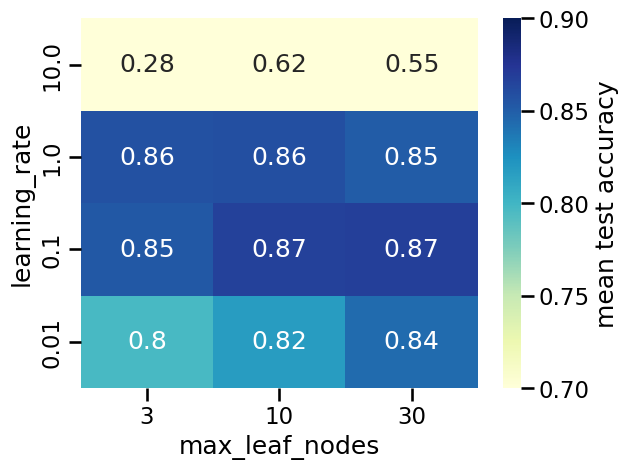

In [17]:
import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results,
    annot=True,
    cmap="YlGnBu",
    vmin=0.7,
    vmax=0.9,
    cbar_kws={"label": "mean test accuracy"},
)
ax.invert_yaxis()

The heatmap above shows the mean test accuracy (i.e., the average over
cross-validation splits) for each combination of hyperparameters, where darker
colors indicate better performance. However, notice that using colors only
allows us to visually compare the mean test score, but does not carry any
information on the standard deviation over splits, making it difficult to say
if different scores coming from different combinations lead to a significantly
better model or not.

The above tables highlights the following things:

* for too high values of `learning_rate`, the generalization performance of
  the model is degraded and adjusting the value of `max_leaf_nodes` cannot fix
  that problem;
* outside of this pathological region, we observe that the optimal choice of
  `max_leaf_nodes` depends on the value of `learning_rate`;
* in particular, we observe a "diagonal" of good models with an accuracy close
  to the maximal of 0.87: when the value of `max_leaf_nodes` is increased, one
  should decrease the value of `learning_rate` accordingly to preserve a good
  accuracy.

The precise meaning of those two parameters will be explained later.

For now we note that, in general, **there is no unique optimal parameter
setting**: 4 models out of the 12 parameter configurations reach the maximal
accuracy (up to small random fluctuations caused by the sampling of the
training set).

In this notebook we have seen:

* how to optimize the hyperparameters of a predictive model via a grid-search;
* that searching for more than two hyperparameters is too costly;
* that a grid-search does not necessarily find an optimal solution.